In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
# import sys

# sys.path.extend(
#     [
#         'src/poultry',
#     ]
# )

In [4]:
import json

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
qrels_nist = pd.read_csv(
    'eval/RTS17/eval_qrelsfile',
    sep='\s+',
    names=['topic', 'q0', 'tweet_id', 'judgment'],
    usecols=['topic', 'tweet_id', 'judgment'],
    header=None,
    index_col=['tweet_id', 'topic'],
    squeeze=True,
)

qrels_nist.name = 'NIST'

In [6]:
qrels_mobile = pd.read_csv(
    'eval/RTS17/gundog/feedback/mobile-majority.txt',
    sep='\s+',
    names=['topic', 'user', 'tweet_id', 'judgment', 'timestamp'],
    usecols=['topic', 'tweet_id', 'judgment'],
    header=None,
    index_col=['tweet_id', 'topic'],
    squeeze=True,
)
qrels_mobile.name = 'Mobile'

In [7]:
_nist = pd.concat([qrels_nist.unstack('topic')], axis=1, keys=['NIST'])
_mobile = pd.concat([qrels_mobile.unstack('topic')], axis=1, keys=['Mobile'])

qrels = _nist.merge(_mobile, how='outer', left_index=True, right_index=True)

_qrels_mobile_or_nist = qrels['Mobile'].fillna(qrels['NIST'])
_qrels_mobile_or_nist = pd.concat([_qrels_mobile_or_nist], axis=1, keys=['Relevance'])

qrels = qrels.merge(
    _qrels_mobile_or_nist, how='outer', left_index=True, right_index=True
)

# qrels.head()

In [32]:
# %%time
point = pd.read_csv(
    'eval/RTS17/gundog/point/ngram-length(3)_feedback-pattern(mobile-majority)_feedback(nist).point',
    names=[
        'Topic', 'tweet_id',
        'Distance to query',
        'Distance to positive', 'Distance to negative',
        'Score',
        'retrieve', 'Possible feedback',
        'Positive', 'Negative',
        'Time', 'retrieved_count'
    ],
    header=None,
    parse_dates=['Time'],
    low_memory=False,
).dropna()

point.sort_values(by=['Time', 'tweet_id', 'Topic'], inplace=True)

point.drop_duplicates(subset=['tweet_id', 'Topic'], inplace=True)
point.set_index(
    [
        'Time',
        'tweet_id', 'Topic',
    ],
    inplace=True,
)

point = point.unstack('Topic')

# point = pd.concat([point], axis=1, keys=['Point'])

point = point.merge(
    qrels, how='left',
    left_index=True, right_index=True,
)

point.columns.names = 'Variable', 'Topic'

In [33]:
topics = list(point['Relevance'].apply(lambda c: c.value_counts()).dropna(axis='columns', how='all').columns.values)
len(topics)

188

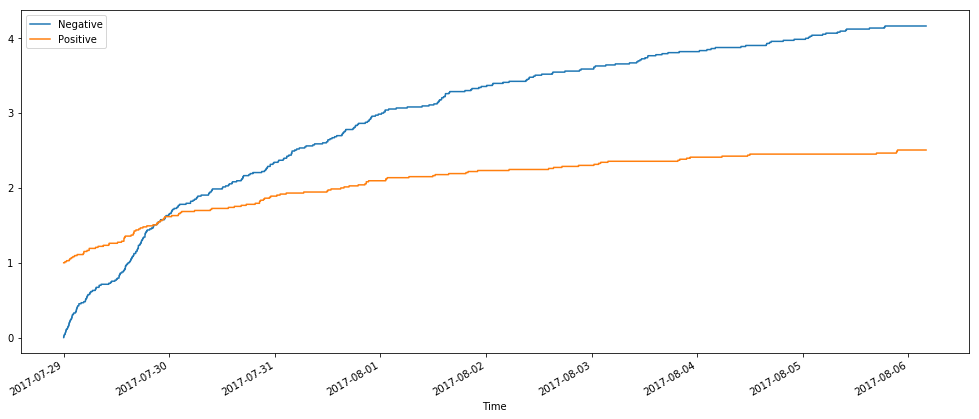

In [34]:
ax = (
    pd.DataFrame(
        {
            'Positive': point['Positive']
            .fillna(1).cummax(axis='rows')
            .mean(axis='columns'),
            'Negative': point['Negative']
            .fillna(0).cummax(axis='rows')
            .mean(axis='columns'),
#             'Total': point['retrieved_count']
#             .fillna(0).cummax(axis='rows')
#             .mean(axis='columns')
        }
    )
    .reset_index('tweet_id', drop=True)
    .plot(
        use_index=True,
        figsize=(17, 7),
    )
)

ax.figure.savefig('eval/RTS17/plots/feedback.pdf')

In [35]:
point['Distance to query'].stack().corr(point['Score'].stack(), method='spearman')

0.78195701455484667

In [36]:
point['Score'].rank().corrwith(point['Distance to query'].rank()).sort_values(ascending=True).mean()

0.87400766139158259

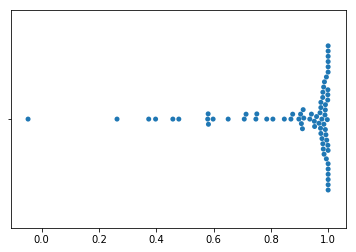

In [37]:
sns.swarmplot(
    point['Score'].rank().corrwith(point['Distance to query'].rank()).sort_values(ascending=False)
);

In [38]:
by_topic = point.stack('Topic').reset_index('Topic').dropna(subset=['Relevance'])

by_topic['Relevance'] = by_topic['Relevance'] > 0
by_topic['Score'].clip(lower=0, upper=2, inplace=True)

In [39]:
# %%time

threshold = 0.8
by_topic['retrieve_query'] = by_topic['Distance to query'] < threshold

# by_topic['Kind'] = ''

# by_topic.loc[
#     (by_topic['retrieve_query'] & by_topic['retrieve'] & by_topic['Relevance']),
#     'Kind'
# ] = 'BothTN'

for what, judgment in [
    ('Kind', 'Relevance'),
    ('Kind (NIST)', 'NIST'),
    ('Kind (Mobile)', 'Mobile'),
]:
    by_topic[what] = by_topic.apply(
        lambda r: {
    #         (True, True, True): 'BothTP',
    #         (True, True, False): 'BothFP',
    #         (False, False, True): 'BothFN',
    #         (False, False, False): 'BothTN',

            (True, True, True): 'Correct',
            (True, True, False): 'Wrong',
            (False, False, True): 'Wrong',
            (False, False, False): 'Correct',        

            (True, False, True): 'ScoreTN',
            (True, False, False): 'ScoreFN',
            (False, True, True): 'ScoreTP',
            (False, True, False): 'ScoreFP',
        }.get(tuple(r.loc[['retrieve_query', 'retrieve', judgment]].values)),
        axis='columns',
    )

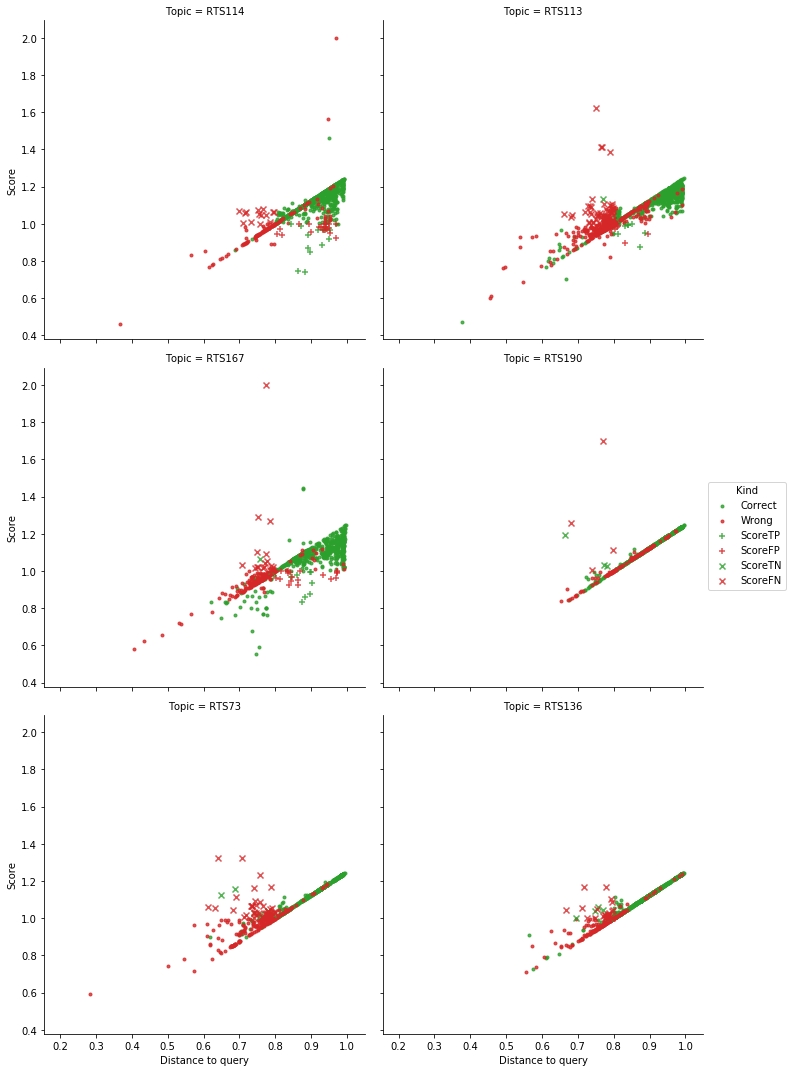

In [40]:
sns.lmplot(
    data=by_topic,
    x='Distance to query', y='Score',
    hue='Kind',
    hue_order=[
#         'BothTP', 'BothFP', # LL
#         'BothTN', 'BothFN', # UR
#         'Relevant', 'Non-relevant',
        'Correct', 'Wrong',
        'ScoreTP', 'ScoreFP', # LR
        'ScoreTN', 'ScoreFN', # UL
    ],
    markers=[
#         '.', '.',
#         '.', '.',
        '.', '.',
        '+', '+',
        'x', 'x',
    ],
    palette = {
#         'BothTP': 'tab:green', 'BothFP': 'tab:red', # LL
#         'BothTN': 'tab:red', 'BothFN': 'tab:green', # UR
        'Correct': 'tab:green', 'Wrong': 'tab:red',
        'Relevant': 'tab:green', 'Non-relevant': 'tab:red',
        'ScoreTP': 'tab:green', 'ScoreFP': 'tab:red', # LR
        'ScoreTN': 'tab:green', 'ScoreFN': 'tab:red', # UL
    },
    col='Topic',
    col_order=[
        'RTS114', 'RTS113',
        'RTS167', 'RTS190',
        'RTS73', 'RTS136',
#         'RTS207', 'RTS204', # TOP: TN, FN
#         'RTS219', 'RTS94', # TOP: TP, FP
# #         'RTS94', 'RTS204',
#         'RTS212', 'RTS48', # FINA, Panera Bread
    ],
    col_wrap=2,
    ci=None,
#     x_jitter=0.004,
#     y_jitter=0.004,
    sharex=True,
    sharey=True,
    fit_reg=False,
);

In [17]:
effect = by_topic.groupby(['Topic', 'Kind']).size().unstack('Kind').fillna(0)

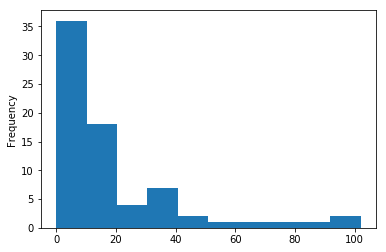

In [18]:
total_effect = effect['ScoreTP'] + effect['ScoreTN'] + effect['ScoreFP'] + effect['ScoreFN']

total_effect.plot.hist();

In [19]:
pd.concat(
    [
        total_effect.sort_values(ascending=False).head(10),
#         total_effect.sort_values(ascending=False).tail(),
    ]
)

Topic
RTS113    102.0
RTS73      93.0
RTS114     89.0
RTS167     73.0
RTS190     66.0
RTS136     58.0
RTS127     48.0
RTS162     45.0
RTS90      40.0
RTS91      39.0
dtype: float64

In [20]:
for what, judgment in [
    ('Error', 'Relevance'),
    ('Error (NIST)', 'NIST'),
    ('Error (Mobile)', 'Mobile'),
]:
    by_topic[what] = by_topic.apply(
        lambda r: {
            (True, True, True): 'TP',
            (True, True, False): 'FP',
            (False, False, True): 'FN',
            (False, False, False): 'TP',        

            (True, False, True): 'TN',
            (True, False, False): 'FN',
            (False, True, True): 'TP',
            (False, True, False): 'FP',
        }.get(tuple(r.loc[['retrieve_query', 'retrieve', judgment]].values)),
        axis='columns',
    )

In [21]:
for what in 'Error', 'Error (NIST)', 'Error (Mobile)':
    _ = by_topic.groupby(['Topic', what]).size().unstack(what).fillna(0)

    _bs = 1 ** 2
    _['F'] = ((1 + _bs) * _.TP) / ((1 + _bs) * _.TP + _bs * _.FN + _.FP)

#     _['F'].plot.hist()

    print('F (avg per topic, {}): {:0.2f}'.format(what, _.F.mean()))

F (avg per topic, Error): 0.78
F (avg per topic, Error (NIST)): 0.79
F (avg per topic, Error (Mobile)): 0.89


In [22]:
for what in 'Error', 'Error (NIST)', 'Error (Mobile)':
    _ = by_topic.groupby(what).size()

    _bs = 1 ** 2
    print(
        'F (over all topics, {}): {:0.2f}'.format(
            what,
            ((1 + _bs) * _.TP) / ((1 + _bs) * _.TP + _bs * _.FN + _.FP)
        )
    )

F (over all topics, Error): 0.77
F (over all topics, Error (NIST)): 0.78
F (over all topics, Error (Mobile)): 0.89


In [ ]:
# (
#     by_topic.loc[
#         (by_topic['Distance to query'] <= 0.8) & (by_topic['retrieve'] == False),
#         ['Topic', 'Relevance']
#     ]
# ).groupby(['Topic', 'Relevance']).size().unstack('Relevance').sort_values(
#     False, # Most improved recall
# #     True, # Most deteriorated recall
#     ascending=False
# ).head()

In [ ]:
# (
#     by_topic.loc[
#         (by_topic['Distance to query'] > 0.8) & (by_topic['retrieve'] == True),
#         ['Topic', 'Relevance']
#     ]
# ).groupby(['Topic', 'Relevance']).size().unstack('Relevance').sort_values(
# #     True, # Most improved precision
#     False, # Most deteriorated precision
#     ascending=False
# ).head()

In [ ]:
# _ = by_topic.groupby('Topic').apply(lambda df: df['Relevance'].value_counts()).unstack(1)
# _['Total'] = _.sum(axis='columns')
# _['True to False']  = _[True] / _[False]
# _.sort_values('True to False', inplace=True, ascending=False)
# _.head(10)

In [ ]:
# sns.swarmplot(
#     data=distance_score.loc['RTS212'], x='Variable', y='Value',
#     hue='Relevance', hue_order=['Non-relevant', 'Relevant'],
#     dodge=True,
# );

In [ ]:
# sns.swarmplot(
#     data=distance_score.loc['RTS48'], x='Variable', y='Value',
#     hue='Relevance', hue_order=['Non-relevant', 'Relevant'],
#     dodge=True,
# );

In [ ]:
# sns.swarmplot(
#     data=distance_score.loc['RTS207'], x='Variable', y='Value',
#     hue='Relevance', hue_order=['Non-relevant', 'Relevant'],
#     dodge=True,
# );

In [ ]:
# sns.swarmplot(
#     data=distance_score.loc['RTS94'], x='Variable', y='Value',
#     hue='Relevance', hue_order=['Non-relevant', 'Relevant'],
#     dodge=True,
# );

In [ ]:
# sns.swarmplot(
#     data=distance_score.loc['RTS47'], x='Variable', y='Value',
#     hue='Relevance', hue_order=['Non-relevant', 'Relevant'],
#     dodge=True,
# );

In [ ]:
# (
#     point
# #     .sort_values(
# #         [
# #     #             ('Relevance', 'RTS212'),
# #                 ('Distance to query', 'RTS212'),
# #     #             ('Distance to query', 'RTS48'),
# #     #             ('Score', 'RTS212'),
# #     #             ('Score', 'RTS48'),
# #     #             ('Relevance', 'RTS212'),
# #     #             ('Relevance', 'RTS48'),
# #         ],
# #         ascending=True,
# #     )
#     [
#         [
#             ('Distance to query', 'RTS212'),
#             ('Score', 'RTS212'),
#             ('retrieve', 'RTS212'),
#             ('Relevance', 'RTS212'),
#             ('Distance to positive', 'RTS212'),
#             ('Distance to negative', 'RTS212'),
#             ('Positive', 'RTS212'),
#             ('Negative', 'RTS212'),
#         ]
#     ]
#     .dropna(subset=[('Relevance', 'RTS212')], axis='rows', how='any')
# )

In [ ]:
# distance_score = (
#     point[['Distance to query', 'Score', 'Relevance', 'retrieve']]
#     .stack(['Topic'])
#     .set_index(['retrieve'] , append=True)
#     .dropna(subset=['Relevance'])
#     .set_index('Relevance', append=True)
#     .stack().to_frame('Value')
#     .reset_index()
#     .set_index(['Topic', 'tweet_id'])
# )
# distance_score = distance_score[distance_score['Relevance'] >= 0]
# distance_score['Relevance'] = distance_score['Relevance'] > 0

# # distance_score.loc[:, 'Value'] = 1 / (1 + np.exp(-distance_score['Value']))

# distance_score.loc[distance_score['Relevance'] > 0, 'Relevance'] = 'Relevant'
# distance_score.loc[distance_score['Relevance'] == 0, 'Relevance'] = 'Non-relevant'

# distance_score['Error'] = distance_score.apply(
#     lambda r: {
#         ('Relevant', True): 'TP',
#         ('Relevant', False): 'FN',
#         ('Non-relevant', True): 'FP',
#         ('Non-relevant', False): 'TN',
#     }[r['Relevance'], r['retrieve'] if r['Variable'] == 'Score' else r['Value'] < 0.8],
#     axis='columns',
# )

In [ ]:
# sns.swarmplot(
#     distance_score.reset_index().set_index('Variable')
#     .loc['Score', ['Topic', 'Relevance']]
#     .reset_index()
#     .groupby(['Topic', 'Relevance'])
#     .size(),
# #     .unstack('Topic')
#     dodge=True,
# );

In [ ]:
# !mkdir -p eval/RTS17/plots/

In [ ]:
# f, ax = plt.subplots(figsize=(14, 7))

# sns.violinplot(
#     data=distance_score, x='Variable', y='Value',
#     hue='Relevance', hue_order=['Non-relevant', 'Relevant'], dodge=True,
#     ax=ax,
# );

# f.savefig('eval/RTS17/plots/distance-score-comparison.pdf')

In [ ]:
# f, ax = plt.subplots(figsize=(14, 7))

# sns.swarmplot(
#     data=distance_score, x='Variable', y='Value', hue='Error',
#     hue_order=[
#         'FN', 'FP', 'TN', 'TP',
#     ],
#     palette={
#         'FN': 'r',
#         'TN': 'g',
#         'FP': 'r',
#         'TP': 'g',
#         'N': 'r',
#         'P': 'g',
#     },
#     dodge=True,
#     ax=ax,
# );

# f.savefig('eval/RTS17/plots/distance-score-comparison-error-type.pdf')

# Mobile asessor agreement over time

In [ ]:
mobile = pd.read_csv(
    'eval/RTS17/qrels-crowd',
    sep='\s+',
    header=None,
    names=['Topic', 'Assessor', 'tweet_id', 'Judgment', 'timestampe'],
    index_col=['Topic', 'tweet_id'],
)

In [ ]:
mobile_judgment = (
    mobile['Judgment']
    .groupby(level=['Topic', 'tweet_id'])
    .value_counts()
    .unstack('Judgment')
    [[0, 1, 2]]
    .fillna(0)
)

In [ ]:
mobile_judgment['Disagreement'] = mobile_judgment.max(axis='columns') != mobile_judgment.sum(axis='columns')

In [ ]:
disagreement = (
    mobile_judgment
    .sort_index()
    [['Disagreement']]
#     .unstack('Topic')
#     .fillna(0)
#     .cumsum(axis='rows')
#     .sum(axis='columns')
#     .plot(use_index=False)
);

In [ ]:
disagreement['position'] = disagreement.groupby(level=['Topic']).cumcount()
disagreement['disagreements'] = disagreement['Disagreement'].groupby(level=['Topic']).cumsum()

In [ ]:
(
    disagreement.loc[
        (disagreement['Disagreement'] & disagreement['disagreements'] == 1),
        'position'
    ]
    .groupby(level=['Topic']).first()
    .value_counts()
#     .sort_values(ascending=False)
    .sort_index()
#     .head(20)
    .plot(kind='bar', figsize=(14,7))
);

In [ ]:
# mobile_judgment.loc['RTS151']